In [1]:
# !pip install seaborn
# !pip install transformers
# !pip install SentencePiece

In [2]:
import pandas as pd
from pathlib import Path
import os
import optuna
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Huggingface Transformers
from transformers import RobertaTokenizer, RobertaForSequenceClassification, DebertaTokenizer, DebertaForSequenceClassification
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizerFast, AlbertTokenizer, AlbertForSequenceClassification

# For eval
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
export_dir = Path(os.getcwd())
data_path = Path(export_dir, "data")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_dir = Path(export_dir, 'models')

test_df = pd.read_csv(Path(data_path,'test_data_only_text_and_labels.csv'))
X_test = test_df["text_combined"]
y_test = test_df["label"]

## Change params here:

In [4]:
model_name = "RoBERTa" #"RoBERTa", DeBERTa, distilbert, ALBERT

chosen_model = "finetune_RoBERTa_epoch_9_acc_0.9948.pt"

In [5]:
class EmailDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.texts = dataframe['text_combined'].tolist()
        self.labels = dataframe['label'].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=512,  ####################### Adjust as needed
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [6]:
if model_name == "RoBERTa": 
    # RoBERTa tokenizer and model
    tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
    model = RobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=2).to(device)
        
        
if model_name == "DeBERTa": 
    # DeBERTa tokenizer and model
    tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-large')
    model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-large', num_labels=2).to(device)

    
if model_name == "distilbert":
    model_name = "distilbert-base-uncased"
    model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

        
if model_name == "ALBERT": 
    # ALBERT tokenizer and model
    tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
    model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2).to(device)


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should 

In [7]:
# Load the saved state_dict of your trained model
path = Path(models_dir, chosen_model)
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [8]:
test_dataset = EmailDataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [9]:
def get_model_size(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / (1024 ** 2)  # Size in MB

total_params = sum(p.numel() for p in model.parameters())

# Get all results here

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
Average Batch Processing Time: 0.1090 seconds
Accuracy: 0.9943629530852225
Precision: 0.9959093034128097
Recall: 0.9932393052803357
F1-Score: 0.9945725124015173
AUC: 0.9996497274736525
 Model size: 1355.5976638793945
Total number of parameters: 355361794
Confusion Matrix:


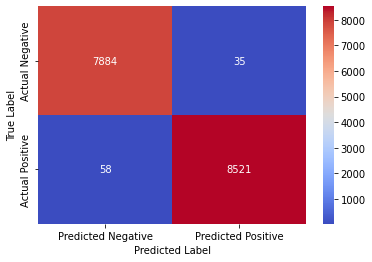

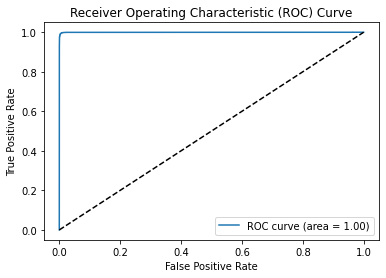

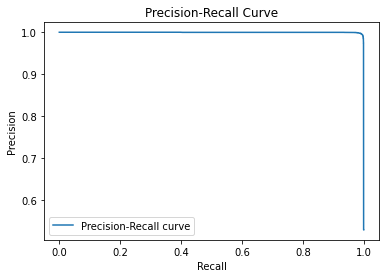

In [10]:
import time

# Put the pruned model in evaluation mode
model.eval()

# Store true labels and predictions
y_true = y_test.values  # True labels (convert to numpy array)
y_pred = []
y_scores = []

# List to store batch processing times
batch_times = []

# Get logits from the model
with torch.no_grad():
    i = 0 
    for batch in test_loader:
        start_time = time.time()  # Start time for this batch
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)  # Get probabilities

        # Get the predicted labels and store them
        predictions = torch.argmax(probs, dim=1)
        y_pred.extend(predictions.cpu().numpy())  # Ensure predictions are on CPU
        y_scores.extend(probs[:, 1].cpu().numpy())  # Store the probability for the positive class
        
        # End time for this batch
        end_time = time.time()
        batch_times.append(end_time - start_time)  # Store the batch processing time

        i += 1
        if i % 50 == 0:
            print(i)

# Convert predictions and scores to numpy arrays
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

# Calculate and print the average batch time
average_batch_time = sum(batch_times) / len(batch_times)
print(f"Average Batch Processing Time: {average_batch_time:.4f} seconds")

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)
print("AUC:", auc)

print(f" Model size: {get_model_size(model)}")
print(f"Total number of parameters: {total_params}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
data = cm
x_labels = ['Predicted Negative', 'Predicted Positive']
y_labels = ['Actual Negative', 'Actual Positive']
# Create the heatmap with values inside cells
ax = sns.heatmap(data, annot=True, fmt='d', cmap='coolwarm', cbar=True, 
                 xticklabels=x_labels, yticklabels=y_labels)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

# ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, y_scores)
plt.figure()
plt.plot(recall_vals, precision_vals, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()